# Image Classification

## Setup and dependencies
Please use this section to list and set up all your required libraries/dependencies and your plotting environment.

In [26]:
# This programme was known to have issue with tf version<=2.15, please update your package
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.optimizers import Adam,SGD
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [27]:
#constant define here
RANDOM_SEED = 0
EPOCH = [10,20,50]
BATCH = 64
NUM_CLASSES = 11

In [28]:
# here I define optimizers with different leaning rate
adam = Adam() #default lr=0.001
adam_001 = Adam(learning_rate=0.01) # lr=0.01
adam_005 = Adam(learning_rate=0.05) # lr=0.05
adam_01 = Adam(learning_rate=0.1) # lr=0.1

sgd = SGD() #default lr=0.01
sgd_005 = SGD(learning_rate=0.05) # lr=0.05
sgd_01 = SGD(learning_rate=0.1) # lr=0.1

OPT=[adam,adam_001,adam_005,adam_01,sgd,sgd_005,sgd_01]

In [29]:
# suppress warnings for better look
import warnings
warnings.filterwarnings('ignore')

In [30]:
# environment initialization
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)
keras.backend.clear_session()

In [31]:
# Code from tutorial, used to show data as images
# Set up inline plotting and figure/axis labels
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

def plot_image(image):
    # Remove redundant extra dimension
    if image.shape[-1] == 1:
        image = image.squeeze(axis=-1)

    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    # Remove redundant extra dimension
    if image.shape[-1] == 1:
        image = image.squeeze(axis=-1)

    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

def plot_examples(data, n_rows=4, n_cols=10):
    """Plot a grid of images which are encoded as numpy arrays."""

    # Remove redundant extra dimension
    if data.shape[-1] == 1:
        data = data.squeeze(axis=-1)


    # Size figure depending on the size of the grid
    plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))

    for row in range(n_rows):
        for col in range(n_cols):

            # Get next index of image
            index = n_cols * row + col

            # Plot the image at appropriate place in grid
            plt.subplot(n_rows, n_cols, index + 1)
            plt.imshow(data[index], cmap="binary")
            plt.axis('off')

    plt.show()

## 1.Data preprocessing

In [32]:
# Load the dataset training and test sets as numpy arrays
x_train = np.load('OrganMNIST_Data/X_train.npy')
y_train = np.load('OrganMNIST_Data/y_train.npy')
x_test = np.load('OrganMNIST_Data/X_test.npy')
y_test = np.load('OrganMNIST_Data/y_test.npy')

### Data Exploration

In [33]:
x_train.shape

(18928, 28, 28)

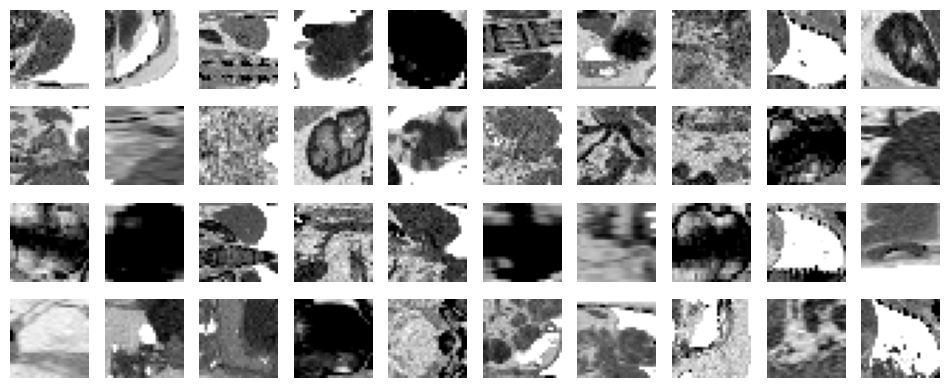

In [34]:
plot_examples(x_train)

In [35]:
y_train.shape

(18928,)

In [36]:
y_train[:20]

array([10,  7,  6,  3,  2,  9, 10,  9,  8,  5,  6,  9,  0,  4,  3,  6,  9,
        9,  1,  9], dtype=uint8)

In [37]:
print(np.max(y_train),np.min(y_train),np.max(x_train),np.min(x_train))
print(np.max(y_test),np.min(y_test),np.max(x_test),np.min(x_test))

10 0 255 0
10 0 255 0


### preprocessing

In [38]:
#preprocess
# rescale x (0,255)->(0,1)
x_train = x_train / 255.
x_test = x_test / 255.
# encode y int->one-hot
y_train = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test = keras.utils.to_categorical(y_test, NUM_CLASSES)

In [39]:
# flatten x
x_test_flattened = np.array(list(map(np.matrix.flatten,x_test)))
x_train_flattened = np.array(list(map(np.matrix.flatten,x_train)))

# get the indices of the maximum values along an axis.
y_test_labels = np.argmax(y_test, axis=1)
y_train_labels = np.argmax(y_train, axis=1)

### data after preprocessing

In [40]:
x_train[0][0]

array([0.75686275, 0.82745098, 0.96078431, 0.72941176, 0.68627451,
       0.80392157, 0.71764706, 0.78823529, 0.7372549 , 0.72156863,
       0.67843137, 0.25490196, 0.16862745, 0.4       , 0.16862745,
       0.22745098, 0.24705882, 0.2745098 , 0.61176471, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        ])

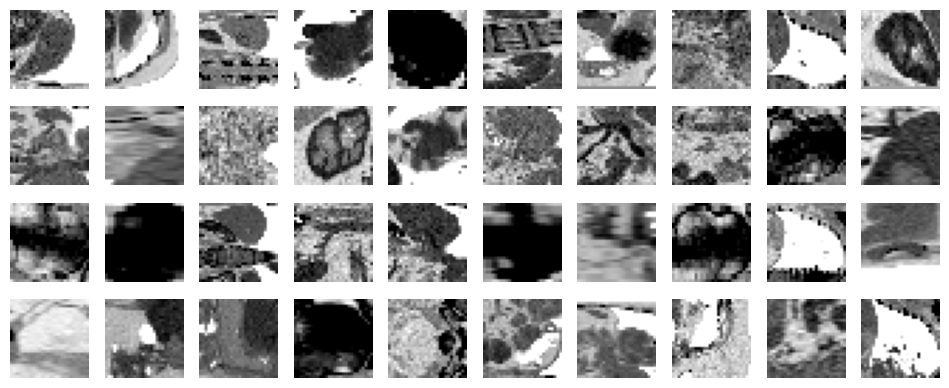

In [41]:
plot_examples(x_train)

In [42]:
y_train[:5]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]])

## 2. Algorithm design and setup

### Algorithm of choice from first six weeks of course

In [43]:
# KNN
def knnClassifier(x, y, xt, yt, **hyperparams):
    kclass = KNeighborsClassifier(**hyperparams)
    kclass.fit(x, y)
    return kclass, kclass.score(xt, yt)

### Fully connected neural network

In [44]:
#run code on gpu
import os
if len(tf.config.list_physical_devices('GPU'))>0:
  os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [45]:
def create_MLP_model(optimizer='adam', activation_function="relu", loss="categorical_crossentropy"):
    model = Sequential([
        layers.Input(shape=(28, 28)),  # Input layer with shape (28, 28)
        layers.Flatten(),  # Flatten layer
        layers.Dense(256, activation=activation_function),  # Dense layer with 256 neurons
        layers.Dense(32, activation=activation_function),  # Dense layer with 32 neurons
        layers.Dense(NUM_CLASSES, activation='softmax')  # Output layer with NUM_CLASSES=11 neurons and softmax activation
    ])

    model.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"])
    return model

### Convolutional neural network

In [46]:
def create_CNN_model(optimizer='adam', dropout=0.5, activation_function="relu", loss="categorical_crossentropy", metrics=["accuracy"]):
    # Define a function to create a Convolutional Neural Network (CNN) model with customizable parameters.


    model = Sequential([  # Create a Sequential model (a linear stack of layers).

        layers.Input(shape=(28, 28, 1)),  # Input layer with the specified input shape.

        # Two convolutional layers with 32 filters of size 3x3, using the specified activation function.
        layers.Conv2D(32, (3, 3), padding='same', activation=activation_function),
        layers.Conv2D(32, (3, 3), padding='same', activation=activation_function),
        layers.MaxPooling2D(pool_size=(2, 2)),  # Max pooling layer to downsample the feature maps.

        # Two convolutional layers with 64 filters of size 3x3, using the specified activation function.
        layers.Conv2D(64, (3, 3), padding='same', activation=activation_function),
        layers.Conv2D(64, (3, 3), padding='same', activation=activation_function),
        layers.MaxPooling2D(pool_size=(2, 2)),  # Max pooling layer.

        # Two convolutional layers with 128 filters of size 3x3, using the specified activation function.
        layers.Conv2D(128, (3, 3), padding='same', activation=activation_function),
        layers.Conv2D(128, (3, 3), padding='same', activation=activation_function),
        layers.MaxPooling2D(pool_size=(2, 2)),  # Max pooling layer.

        layers.Flatten(), # Flatten layer to convert the 2D feature maps to a 1D feature vector.

        layers.Dense(128, activation=activation_function),  # Fully connected layer with 128 units and the specified activation function.

        layers.Dropout(dropout),  # Dropout layer to prevent overfitting by randomly setting a fraction of inputs to zero.

        layers.Dense(NUM_CLASSES, activation='softmax') # Output layer with NUM_CLASSES=11 units and softmax activation for multiclass classification.
    ])

    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)  # Compile the model with the specified optimizer, loss function, and evaluation metrics.

    return model  # Return the compiled model.

## 3. Hyperparameter tuning

In [47]:
keras_classifier_MLP = KerasClassifier(model=create_MLP_model,optimizer='adam',activation_function='relu',loss='categorical_crossentropy',epochs=20,verbose=0)
keras_classifier_CNN = KerasClassifier(model=create_CNN_model,optimizer='adam',activation_function='relu',dropout=0.5,loss='categorical_crossentropy',epochs=20,verbose=0)

### Algorithm of choice from first six weeks of course
Fine tuning with GridsearhCV

In [23]:
# Set the hyperparameters for the KNN classifier
param_grid_KNN = {
    'n_neighbors': [3, 5, 7],  # Values to search for number of neighbors
    'p': [1, 2]  # Values to search for distance metric (1: Manhattan, 2: Euclidean)
}

search_knn = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=param_grid_KNN, cv=3, verbose=1, scoring='accuracy',n_jobs=-1)

search_knn.fit(x_train_flattened, y_train)

print("Best parameters found: ", search_knn.best_params_)
print("Best cross-validation score: %.2f" % search_knn.best_score_)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best parameters found:  {'n_neighbors': 3, 'p': 1}
Best cross-validation score: 0.86


### Fully connected neural network
Fine tuning with GridsearhCV

In [24]:
# Change build_fn to model as recommended by the warning
param_grid_MLP = {
    'optimizer': OPT,
    'activation_function': ['relu', 'sigmoid'],
    'loss': ['categorical_crossentropy'],
    'epochs': EPOCH
}

search_MLP = GridSearchCV(
    estimator=keras_classifier_MLP,
    param_grid=param_grid_MLP,
    cv=3,
    verbose=1,
    scoring='accuracy',
    n_jobs=-1
)

# Assume x_train and y_train are defined
search_MLP.fit(x_train, y_train_labels)

print("Best parameters found: ", search_MLP.best_params_)
print("Best cross-validation score: {:.2f}".format(search_MLP.best_score_))
# here to read out the optimizer
for i in range(len(OPT)):
    if OPT[i] == search_MLP.best_params_['optimizer']:
        print('the',i+1,'th optimizer is the best')
        break

Fitting 3 folds for each of 42 candidates, totalling 126 fits
Best parameters found:  {'activation_function': 'relu', 'epochs': 50, 'loss': 'categorical_crossentropy', 'optimizer': <keras.src.optimizers.sgd.SGD object at 0x000001AA6E0DEB10>}
Best cross-validation score: 0.87
the 6 th optimizer is the best


The epochs is 50 which shows that the learning rate is small

### Convolutional neural network
Fine tuning with GridsearhCV

In [25]:
param_grid_CNN = {
    'optimizer': OPT,
    'activation_function': ['relu', 'sigmoid'],
    'loss': ['categorical_crossentropy'],
    'epochs': EPOCH,
    'dropout': [0.3,0.5,0.7]
}

search_CNN = GridSearchCV(
    estimator=keras_classifier_CNN,
    param_grid=param_grid_CNN,
    cv=3,
    verbose=1,
    scoring='accuracy',
    n_jobs=-1
)

search_CNN.fit(x_train, y_train_labels, verbose=0)

print("Best parameters found: ", search_CNN.best_params_)
print("Best cross-validation score: {:.2f}".format(search_CNN.best_score_))
# here to read out the optimizer for MLP
for i in range(len(OPT)):
    if OPT[i] == search_MLP.best_params_['optimizer']:
        print('the',i+1,'th optimizer is the best')
        break

Fitting 3 folds for each of 126 candidates, totalling 378 fits
Best parameters found:  {'activation_function': 'relu', 'dropout': 0.5, 'epochs': 50, 'loss': 'categorical_crossentropy', 'optimizer': <keras.src.optimizers.adam.Adam object at 0x000001AA6E0CFA50>}
Best cross-validation score: 0.96
the 6 th optimizer is the best


In [34]:
# here to read out the optimizer for CNN
for i in range(len(OPT)):
    if OPT[i] == search_CNN.best_params_['optimizer']:
        print('the',i+1,'th optimizer is the best')
        break

the 4 th optimizer is the best


## 4. Final models
In this section, please ensure to include cells to train each model with its best hyperparmater combination independently of the hyperparameter tuning cells, i.e. don't rely on the hyperparameter tuning cells having been run.

### Algorithm of choice from first six weeks of course

In [52]:
# Now, to train the model using the best parameters:
# best parameters are set according to grid search
best_n_neighbors = 3
best_p = 1


# Initialize KNeighborsClassifier with the best parameters
best_knn_model = KNeighborsClassifier(n_neighbors=best_n_neighbors, p=best_p)

# Train the model using the best parameters and your training data
best_knn_model.fit(x_train_flattened, y_train)

# Predict test labels
y_pred_knn = best_knn_model.predict(x_test_flattened)

# Calculate accuracy
accuracy_knn = accuracy_score(y_test, y_pred_knn)

print("Test accuracy: {:.2f}".format(accuracy_knn))

Test accuracy: 0.91


### Fully connected neural network

In [51]:
best_params = search_MLP.best_params_
best_optimizer = best_params['optimizer']
best_activation_function = best_params['activation_function']
best_loss = best_params['loss']
best_epoch = best_params['epochs']

best_mlp_model = create_MLP_model(optimizer=best_optimizer, activation_function=best_activation_function, loss=best_loss)

# Train the model using the best parameters and your training data
history_mlp = best_mlp_model.fit(x_train, y_train, epochs=best_epoch, verbose=1)

# Predict test labels
y_pred_mlp = best_mlp_model.predict(x_test)

# Convert probabilities to class labels
y_pred_labels_mlp = np.argmax(y_pred_mlp, axis=1)

# Calculate accuracy
accuracy_mlp = accuracy_score(y_test_labels, y_pred_labels_mlp)

print("Test accuracy: {:.2f}".format(accuracy_mlp))


Epoch 1/50
592/592 ━━━━━━━━━━━━━━━━━━━━ 1s 652us/step - accuracy: 0.4717 - loss: 1.5700
Epoch 2/50
592/592 ━━━━━━━━━━━━━━━━━━━━ 0s 606us/step - accuracy: 0.7014 - loss: 0.9098
Epoch 3/50
592/592 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step - accuracy: 0.7487 - loss: 0.7756
Epoch 4/50
592/592 ━━━━━━━━━━━━━━━━━━━━ 0s 584us/step - accuracy: 0.7780 - loss: 0.6892
Epoch 5/50
592/592 ━━━━━━━━━━━━━━━━━━━━ 0s 579us/step - accuracy: 0.7978 - loss: 0.6246
Epoch 6/50
592/592 ━━━━━━━━━━━━━━━━━━━━ 0s 589us/step - accuracy: 0.8112 - loss: 0.5740
Epoch 7/50
592/592 ━━━━━━━━━━━━━━━━━━━━ 0s 579us/step - accuracy: 0.8249 - loss: 0.5301
Epoch 8/50
592/592 ━━━━━━━━━━━━━━━━━━━━ 0s 591us/step - accuracy: 0.8390 - loss: 0.4911
Epoch 9/50
592/592 ━━━━━━━━━━━━━━━━━━━━ 0s 583us/step - accuracy: 0.8505 - loss: 0.4550
Epoch 10/50
592/592 ━━━━━━━━━━━━━━━━━━━━ 0s 676us/step - accuracy: 0.8617 - loss: 0.4241
Epoch 11/50
592/592 ━━━━━━━━━━━━━━━━━━━━ 0s 592us/step - accuracy: 0.8682 - loss: 0.3966
Epoch 12/50
592/592 ━━━━━━━━━━

### Convolutional neural network

In [48]:
best_params_cnn = search_CNN.best_params_
best_optimizer_cnn = SGD(learning_rate=0.05) # set according to grid search
best_activation_function_cnn = best_params_cnn['activation_function']
best_loss_cnn = best_params_cnn['loss']
best_dropout_cnn = best_params_cnn['dropout']
best_epoch_cnn = best_params_cnn['epochs']

best_model_cnn = create_CNN_model(optimizer=best_optimizer_cnn, activation_function=best_activation_function_cnn, loss=best_loss_cnn, dropout=best_dropout_cnn)

# Train the model using the best parameters and your training data
history_cnn = best_model_cnn.fit(x_train, y_train, epochs=best_epoch_cnn, verbose=1)

# Predict test labels
y_pred_cnn = best_model_cnn.predict(x_test)

# Convert probabilities to class labels
y_pred_labels_cnn = np.argmax(y_pred_cnn, axis=1)

# Calculate accuracy
accuracy_cnn = accuracy_score(y_test_labels, y_pred_labels_cnn)

print("Test accuracy: {:.2f}".format(accuracy_cnn))

Epoch 1/50
592/592 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - accuracy: 0.3491 - loss: 1.9366
Epoch 2/50
592/592 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - accuracy: 0.7423 - loss: 0.7897
Epoch 3/50
592/592 ━━━━━━━━━━━━━━━━━━━━ 18s 31ms/step - accuracy: 0.8343 - loss: 0.5133
Epoch 4/50
592/592 ━━━━━━━━━━━━━━━━━━━━ 19s 33ms/step - accuracy: 0.8693 - loss: 0.3947
Epoch 5/50
592/592 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - accuracy: 0.8902 - loss: 0.3235
Epoch 6/50
592/592 ━━━━━━━━━━━━━━━━━━━━ 19s 32ms/step - accuracy: 0.9141 - loss: 0.2548
Epoch 7/50
592/592 ━━━━━━━━━━━━━━━━━━━━ 19s 32ms/step - accuracy: 0.9269 - loss: 0.2128
Epoch 8/50
592/592 ━━━━━━━━━━━━━━━━━━━━ 19s 31ms/step - accuracy: 0.9346 - loss: 0.1975
Epoch 9/50
592/592 ━━━━━━━━━━━━━━━━━━━━ 19s 32ms/step - accuracy: 0.9443 - loss: 0.1598
Epoch 10/50
592/592 ━━━━━━━━━━━━━━━━━━━━ 19s 32ms/step - accuracy: 0.9505 - loss: 0.1380
Epoch 11/50
592/592 ━━━━━━━━━━━━━━━━━━━━ 19s 32ms/step - accuracy: 0.9537 - loss: 0.1282
Epoch 12/50
592/592 ━━━━━━━━━━

## 5. Model Performance
Below show the models performance for all of three model

### Algorithm of choice from first six weeks of course

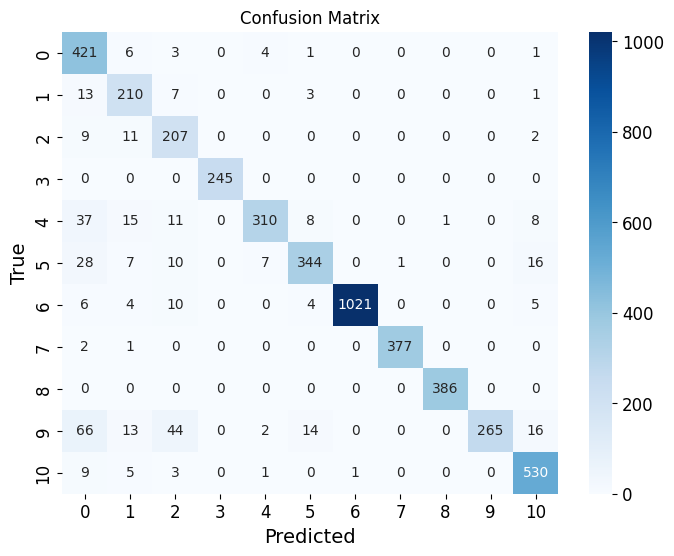

Classification Report for KNN Model:
              precision    recall  f1-score   support

           0       0.71      0.97      0.82       436
           1       0.77      0.90      0.83       234
           2       0.70      0.90      0.79       229
           3       1.00      1.00      1.00       245
           4       0.96      0.79      0.87       390
           5       0.92      0.83      0.87       413
           6       1.00      0.97      0.99      1050
           7       1.00      0.99      0.99       380
           8       1.00      1.00      1.00       386
           9       1.00      0.63      0.77       420
          10       0.92      0.97      0.94       549

    accuracy                           0.91      4732
   macro avg       0.91      0.91      0.90      4732
weighted avg       0.93      0.91      0.91      4732



In [53]:
# Convert probabilities to class labels
y_test_labels = np.argmax(y_test, axis=1)
y_pred_knn_labels = np.argmax(y_pred_knn, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(y_test_labels, y_pred_knn_labels)

# Plot the confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d',cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Generate classification report
classification_report_knn = classification_report(y_test_labels, y_pred_knn_labels)
print("Classification Report for KNN Model:")
print(classification_report_knn)

### Fully connected neural network

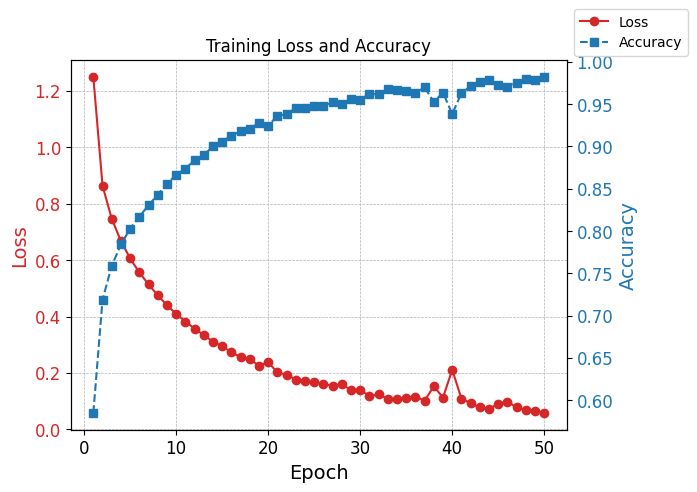

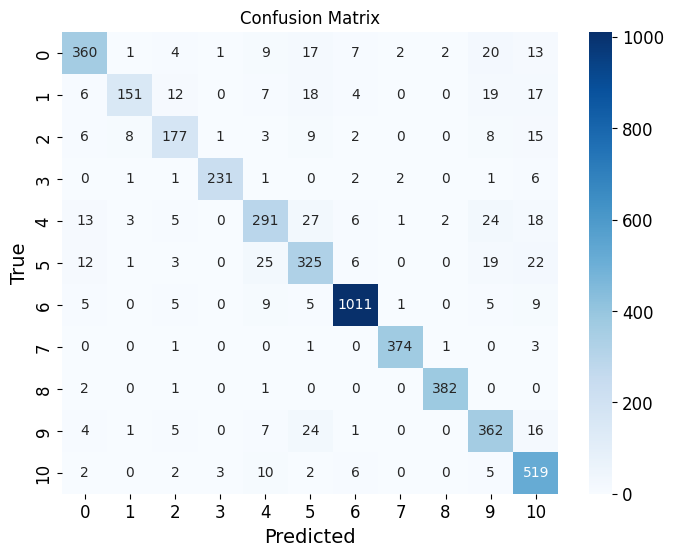

Classification Report for MLP Model:
              precision    recall  f1-score   support

           0       0.88      0.83      0.85       436
           1       0.91      0.65      0.76       234
           2       0.82      0.77      0.80       229
           3       0.98      0.94      0.96       245
           4       0.80      0.75      0.77       390
           5       0.76      0.79      0.77       413
           6       0.97      0.96      0.97      1050
           7       0.98      0.98      0.98       380
           8       0.99      0.99      0.99       386
           9       0.78      0.86      0.82       420
          10       0.81      0.95      0.87       549

    accuracy                           0.88      4732
   macro avg       0.88      0.86      0.87      4732
weighted avg       0.89      0.88      0.88      4732



In [ ]:
epochs = range(1, 51)  # Adjust the range based on the number of epochs you have

fig, ax1 = plt.subplots()

# Plotting the loss on the primary y-axis
color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
ax1.plot(epochs, history_mlp.history['loss'], color=color, marker='o', linestyle='-', label='Loss')
ax1.tick_params(axis='y', labelcolor=color)

# Creating a second y-axis for the accuracy
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Accuracy', color=color)
ax2.plot(epochs, history_mlp.history['accuracy'], color=color, marker='s', linestyle='--', label='Accuracy')
ax2.tick_params(axis='y', labelcolor=color)

# Adding grid lines
ax1.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5)

# Adding a title
plt.title('Training Loss and Accuracy')

# Move the legend outside the plot area
fig.legend(loc='upper right', bbox_to_anchor=(1.1, 1))

plt.show()

# Generate a confusion matrix for the MLP model
cm = confusion_matrix(y_test_labels, y_pred_labels_mlp)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Generate classification report
classification_report_mlp = classification_report(y_test_labels, y_pred_labels_mlp)
print("Classification Report for MLP Model:")
print(classification_report_mlp)

### Convolutional neural network

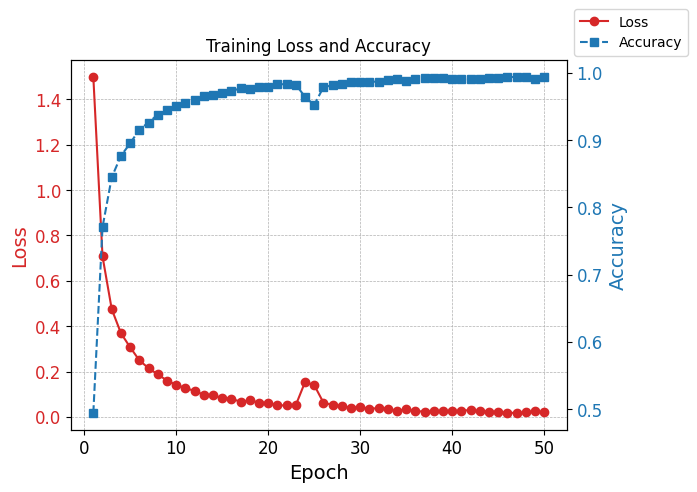

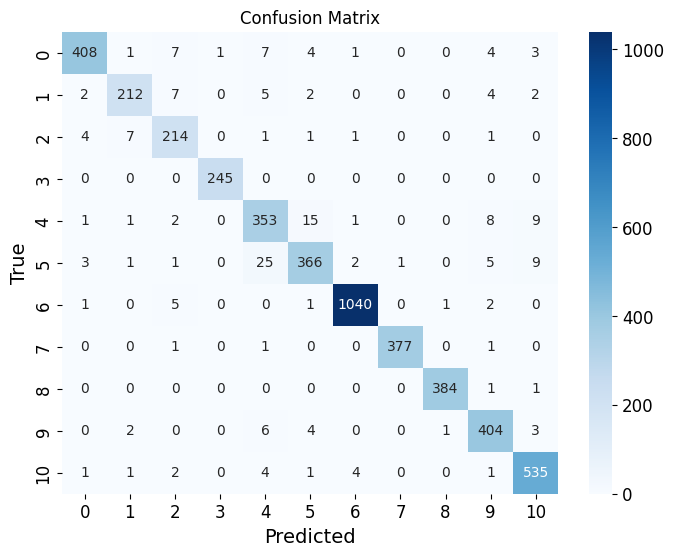

Classification Report for CNN Model:
              precision    recall  f1-score   support

           0       0.97      0.94      0.95       436
           1       0.94      0.91      0.92       234
           2       0.90      0.93      0.91       229
           3       1.00      1.00      1.00       245
           4       0.88      0.91      0.89       390
           5       0.93      0.89      0.91       413
           6       0.99      0.99      0.99      1050
           7       1.00      0.99      0.99       380
           8       0.99      0.99      0.99       386
           9       0.94      0.96      0.95       420
          10       0.95      0.97      0.96       549

    accuracy                           0.96      4732
   macro avg       0.95      0.95      0.95      4732
weighted avg       0.96      0.96      0.96      4732



In [55]:
epochs = range(1, 51)  # Adjust the range based on the number of epochs you have

fig, ax1 = plt.subplots()

# Plotting the loss on the primary y-axis
color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
ax1.plot(epochs, history_cnn.history['loss'], color=color, marker='o', linestyle='-', label='Loss')
ax1.tick_params(axis='y', labelcolor=color)

# Creating a second y-axis for the accuracy
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Accuracy', color=color)
ax2.plot(epochs, history_cnn.history['accuracy'], color=color, marker='s', linestyle='--', label='Accuracy')
ax2.tick_params(axis='y', labelcolor=color)

# Adding grid lines with reduced frequency
ax1.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5)

# Adding a title
plt.title('Training Loss and Accuracy')

# Move the legend outside the plot area
fig.legend(loc='upper right', bbox_to_anchor=(1.1, 1))

plt.show()

# Generate a confusion matrix for the CNN model
cm = confusion_matrix(y_test_labels, y_pred_labels_cnn)
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Generate classification report
classification_report_cnn = classification_report(y_test_labels, y_pred_labels_cnn)
print("Classification Report for CNN Model:")
print(classification_report_cnn)